In [1]:
from __future__ import print_function

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,ReduceLROnPlateau

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
# from tensorflow.keras.datasets import mnist, cifar10
import tensorflow_addons as tfa

import sklearn
from itertools import chain

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.io import loadmat 
import mat73
from datetime import datetime
import ipynbname

print("Packages Loaded")

Packages Loaded


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      #tf_config = tf.ConfigProto(allow_soft_placement=False)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import wandb
from wandb.keras import WandbCallback
time_stamp = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')
wandb.init(project="my-test-project", entity="ibksolar", name=ipynbname.name()+time_stamp,config ={} )
 
config = wandb.config

wandb: Currently logged in as: ibksolar (use `wandb login --relogin` to force relogin)


In [4]:
# Load data
# raw_data1 = loadmat('new_echo_cnn_in_out_jstarrs2021_first_try/echo_cnn_in_out_jstars1.mat')
# raw_data1 = loadmat('echo_cnn_in_out_GOOD_layers/new_echo_cnn_in_out_jstars1.mat') 'findpeaks_layers/new_echo_cnn_in_out_jstars1.mat'
load_old_data = True

if load_old_data:
    raw_data1 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars1.mat')
    raw_data2 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars2.mat')
    raw_data3 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars3.mat')
    # raw_data4 = loadmat('findpeaks_layers_rowblock20/new_echo_cnn_in_out_jstars4.mat')

    d1 = raw_data1['echo_cnn1']
    t1 = raw_data1['echo_target1']
    i1 = raw_data1['echo_idx1']
    c1 = raw_data1['coords1']

    d2 = raw_data2['echo_cnn2']
    t2 = raw_data2['echo_target2']
    i2 = raw_data2['echo_idx2']
    c2 = raw_data2['coords2']

    d3 = raw_data3['echo_cnn3']
    t3 = raw_data3['echo_target3']
    i3 = raw_data3['echo_idx3']
    c3 = raw_data3['coords3']

    # d4 = raw_data4['echo_cnn4']
    # t4 = raw_data4['echo_target4']
    # i4 = raw_data4['echo_idx4']


    orig_all_data = np.concatenate( (d1,d2,d3),axis = 0 )
    orig_all_target = np.concatenate( (t1,t2,t3),axis = 0 )
    orig_all_idx = np.concatenate( (i1,i2,i3),axis = 0 )
    coords = np.concatenate( (c1,c2,c3),axis = 0 )

    # Set all nan in the data to zero
    nan_idx = np.isnan(orig_all_data).any(axis =-1)
    orig_all_target[nan_idx] = 0
    orig_all_data[ np.isnan(orig_all_data) ]= 0

In [5]:
load_new_data = False

if load_new_data:
    # base_path = '..\\..\\all_block_data\Dec_Train_block_len_21_011121_2331'
    #base_path = '../all_block_data/Old_data/Dec_Train_block_len_21_231121_1531'
    #base_path = '../all_block_data\PulsedTrainTest\Dec_Train_block_len_25_150322_1554'
    base_path = 'Y:\\ibikunle\\Python_Project\\Fall_2021\\all_block_data\\Attention_Train_data\\Train_data\\20120330_04_5km'
    # Confirm path is right...
    print(f'{os.path.isdir(base_path)}')

In [6]:
if load_new_data:
    raw_data1 = mat73.loadmat(base_path + '/echo_cnn_in_out_jstars.mat')
    all_data = raw_data1['echo_cnn_input']
    all_target = raw_data1['echo_cnn_target']
    all_coords = raw_data1['coords']
    echo_idx = raw_data1['orig_echo_idx']

    # Set all nan in the data to zero
    nan_idx = np.isnan(all_data).any(axis =-1)
    all_target[nan_idx] = 0
    all_data[ np.isnan(all_data) ]= 0


    orig_all_data = all_data
    orig_all_target = all_target
    orig_all_idx = echo_idx
    coords = all_coords

In [7]:
# Split based on echograms into small dataset representing training and testing.

config['reduce_test_set'] = False

all_echo_idx = np.unique(orig_all_idx)

# Start split 
#test_echo_idx = list(chain.from_iterable( [ list(range(20*n+1,20*n+20)) for n in range(1,int(max(all_echo_idx))//20,2) ] ) )

# New training should stop at 1225: Final test set starts from echogram 119 in original imb.picker echograms
test_echo_idx = list(chain.from_iterable( [ list(range(20*n+1,20*n+20)) for n in range(1,max(all_echo_idx)//20,2) ] ) )


# list(set(test_echo_idx) & set(train_echo_idx))

if config['reduce_test_set']:
    #random.Random(13).shuffle(test_echo_idx)
    test_start = 50 ; test_stop = 100 #test_start+round(0.3*len(test_echo_idx))
    test_echo_idx = test_echo_idx[test_start:test_stop]
   

# Create train_echo_idx     
train_echo_idx = [int(elem) for elem in all_echo_idx if elem not in test_echo_idx]

# Create new coords idx for each rowblock from all the echograms
val_cnt = [ (orig_all_idx==elem).sum() for elem in train_echo_idx]
new_coords = []
for elem in val_cnt:
    new_coords.append([*range(elem)])
new_coords = np.concatenate(new_coords).ravel()

# Get all idx of echos in train_echo_idx ( Might need to find a faster implementation)
#search_idx = np.where(orig_all_idx == train_echo_idx) #np.where( np.in1d(all_idx,train_echo_idx) )
search_idx = []
for echo_idx in train_echo_idx:
    search_idx.append( np.where(orig_all_idx == echo_idx)[0] )
search_idx = list(chain(*search_idx))

all_data = orig_all_data[search_idx]
all_target = orig_all_target[search_idx]
all_idx = orig_all_idx[search_idx]

np.testing.assert_equal(new_coords.shape[0],all_data.shape[0])

In [8]:
# Standardize all_data
standardize = False
if standardize:
    all_data  = ( all_data - all_data.mean() ) / all_data.std()

scale_data = False
if scale_data:
    all_data = 255*all_data

In [9]:
# Truncate data because data after truncate point is not good for training

truncate_data = False
if truncate_data:    
    echo_idx = np.asarray(echo_idx)
    stop_val = 400

    stop_list, = np.where(echo_idx == stop_val)
    stop_idx = stop_list[-1]

    all_data = all_data[:stop_idx]
    all_target = all_target[:stop_idx]

    print(f'Data shape {all_data.shape}')
    print(f'Target shape {all_target.shape}')


In [10]:
config['row_length'] = 21 # CHANGE HERE <==
config['col_length'] = 15

# Check that the dimension of data is correct
if all_data.shape[1] == config['row_length']*config['col_length']:
    print('Dimensions match')
else:
    print(f' Row block length:{config["row_length"]} and col length:{config["col_length"]} does not match Data dimension:{all_data.shape[1]}') 
        

Dimensions match


In [11]:
# Positional Encoding

if 0 :
    time_seq = 9 #col_length #5
    # all_coords = raw_data1['coords']
    all_coord_exp = np.zeros((all_coords.shape[0],time_seq,row_length))

    for idx in range(len(all_coords)):
        a,b,c,_ = np.asarray(all_coords[idx],dtype="int")
        if (a%2) == 0: # If row index is even - this isn't implemented well because it requires iterating through individual rows
            all_coord_exp[idx] = np.sin( np.outer( np.arange(c,c+time_seq), pow(10000, (2*np.arange(a,b)/row_length)) ) )
        else:
            all_coord_exp[idx] = np.cos( np.outer( np.arange(c,c+time_seq), pow(10000, (2*np.arange(a,b)/row_length)) ) )

    if 0: #truncate_data:
        difficult_coords = all_coord_exp[stop_idx+1:]         
        all_coord_exp = all_coord_exp[:stop_idx]        


    all_coord_exp.shape    

In [12]:
seq_length = 9

# Create Coords matrix to be used for Positional Embedding
new_coords_mtx = np.zeros( (len(new_coords),seq_length) )

for idx,each_coord in enumerate(new_coords):
    new_coords_mtx[idx] = np.linspace(0, each_coord, num=seq_length)

In [13]:
max_class = config['row_length'] 

# Highest class is mapped to row_length+1
all_target[all_target == max_class+1 ] = 0


shuffle = 1
if shuffle:
    random.Random(13).shuffle(all_data)
    random.Random(13).shuffle(all_target)
    # random.Random(13).shuffle(all_coord_exp)
    random.Random(13).shuffle(new_coords_mtx)

## Prep data
train_size = int(np.floor(0.60*len(all_target)));
test_size = int(np.round( 0.20* all_data.shape[0] ))
val_size = all_data.shape[0] -train_size - test_size

mid_pt = 8
neigh =  4

x_train = all_data[0:train_size,:]
x_train = np.reshape( x_train, (x_train.shape[0],max_class,-1),order ='F' )
x_train = x_train[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
x_train = np.transpose(x_train,(0,2,1))
coords_train = new_coords_mtx[0:train_size,:]


x_test = all_data[train_size:train_size+test_size,:]
x_test = np.reshape( x_test,(x_test.shape[0],max_class,-1), order ='F' )
x_test = x_test[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_test = np.reshape(x_test,(x_test.shape[0],-1))
x_test = np.transpose(x_test,(0,2,1))
coords_test = new_coords_mtx[train_size:train_size+test_size,:]


x_val = all_data[-val_size:,:]
x_val = np.reshape( x_val,(x_val.shape[0],max_class,-1), order ='F' )
x_val = x_val[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_val = np.reshape(x_val,(x_val.shape[0],-1))
x_val = np.transpose(x_val,(0,2,1))
coords_val = new_coords_mtx[-val_size:,:]


y_train = all_target[:train_size]
y_test  = all_target[train_size:train_size+test_size]
y_val = all_target[-val_size:]

var_input_shape = x_train.shape[1:] # 240 columns
config['num_classes'] = max_class+1 # layers


# Convert labels to categorical orthonormal vectors
y_train_1hot = tf.keras.utils.to_categorical(y_train, config['num_classes'])
y_test_1hot  = tf.keras.utils.to_categorical(y_test, config['num_classes'])

print(f'Shape of X_train:{x_train.shape}  X_test:{x_test.shape}')
print(f'Shape of y_train:{y_train.shape}  y_test:{y_test.shape}')

Shape of X_train:(665510, 9, 21)  X_test:(221837, 9, 21)
Shape of y_train:(665510, 1)  y_test:(221837, 1)


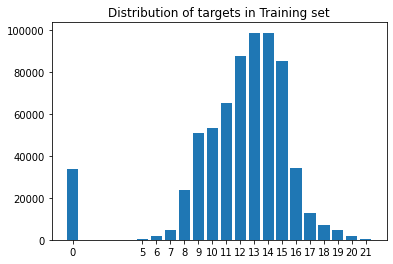

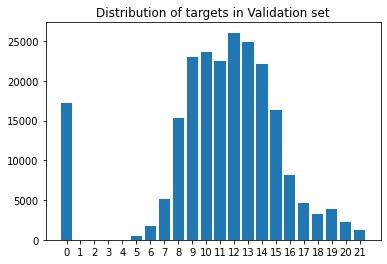

In [14]:
# Show distribution of targets in training and validation set

labels, counts = np.unique(y_train, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Training set')
_ = plt.show()


labels, counts = np.unique(y_val, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Validation set')
_ = plt.show()

In [15]:
x_train2 = np.stack((x_train,)*3, axis=-1)
x_test2 = np.stack((x_test,)*3, axis=-1)
x_val2 = np.stack((x_val,)*3, axis=-1)

In [16]:
# Populate the param 

# import sys,importlib
#importlib.reload(sys.modules['model_hyper_param_log'])
if 1:
    
    base_path =  r'Y:\ibikunle\Python_Project\Fall_2021\all_block_data\PulsedTrainTest\LSTM_PositionalEmbedding'
    log ={}
    log['Notebook_name'] = ipynbname.name()
    log['Uniqueness_of_each_run'] = 'Adding augmentation: Training again_Now July2022: Back to old filtered_data: Hopefully, the final time. '
    log['base_dir'] = base_path
    log['Train_shape'] = x_train.shape
    log['Output_shape'] = ''
    log['num_epochs'] = ''
    log['batch_size'] = ''
    log['activation_function'] = ''
    log['optimizer'] = ''
    log['learning_rate'] = ''
    log['loss_finction'] = ''
    log['accuracy'] = []
    log['loss'] = []
    log['stop_time'] = ''
    log['Model_config'] = ''
    log['Performance_on_test_set'] = ''
    log['output_path'] = ''  # output: where the trained model is saved
    log['shuffle'] = shuffle
    log['run_completion_comment'] = '' # Comment on training and probably evaluation too
    log['extras'] = [{'standardize':standardize}]


from model_hyper_param_log import create_log_entry, update_log_entry
if "log_idx" in globals():
    log["S_N"] = log_idx
log_idx = create_log_entry('../testing_sheet2.xlsx', log)

Could not get file name: auto-generating name


KeyError: 'Uniqueness_of_each_run'

In [ ]:
# Visualize some of the input
rand_idx = random.choice( range(1,x_train.shape[0]) )
_ = plt.plot(x_train[rand_idx].flatten())
_ = plt.title(f'Index {rand_idx}___Target_value:{y_train[rand_idx]}' )
_ = plt.grid(which='both')

In [17]:
data_augmentation = tf.keras.Sequential(
    [
        #layers.Rescaling(1 / 255.0),        
        layers.RandomCrop(x_train.shape[1], x_train.shape[2]),
        layers.RandomFlip("vertical"),
        layers.RandomFlip("horizontal"),
        layers.RandomContrast(0.2),
        
    ],
    name="data_augmentation",
)

In [ ]:
use_class_weight = False

if use_class_weight:
    each_class,each_count = np.unique(y_train, return_counts = True)
    class_weights = len(y_train) / ( len(each_class) * each_count )
    cl_weight_dict = dict(zip(each_class,class_weights))
    

In [ ]:
# Copied from Augment_Reduce: Dealing with overfitting #Custom ResNet + LSTM model
config['Run_notes']='Training again_ june2022: Back to Old filtered_filtered_data but using frames170-243 as final test'
config['num_epochs'] = 500
config['batch_size'] = 128
config['learning_rate'] = 1e-3
config['base_path'] = base_path

# Default hyper-param
config['head_size'] = 1024 
config['mlp_units']= [1024,512,256] 
config['mlp_dropout']= 0.4
config['dropout']= 0.1          
config['r_dropout'] = 0.3

input_shape = (x_train2.shape[1:])# + (1,) #input_shape = (21,5,) #x_train.shape[2]
pos_input_shape = (coords_train.shape[1:])

def ResNetBlock(x,dropout):
    
    # TO DO: Check input dimension    
   
    x = tf.expand_dims(x, axis=-1)
    
    x =   layers.Conv2D(filters=64, kernel_size=(25,15), padding="same")(x) #input_layer
    conv1 = layers.Conv2D(filters=64, kernel_size=(25,15), padding="same")(x) # input_layer, Conv1D
    conv1 = layers.Dropout(dropout)(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv2D(filters=64, kernel_size=(7,5), padding="same")(conv1)
    conv2 = layers.Dropout(dropout)(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.Dropout(dropout)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    # conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    # conv3 = layers.Dropout(dropout)(conv3)
    # conv3 = layers.BatchNormalization()(conv3)
    # conv3 = layers.ReLU()(conv3)
    
    x = layers.add([x,conv3])
    #x = layers.ReLU()(conv3) # Overwrite x
    
    return x


def build_model(
    input_shape,
    head_size,  
    #mlp_units,
    r_dropout,
    mlp_dropout,
):
    inputs = tf.keras.Input(shape=input_shape) 
    pos_inputs = tf.keras.Input(shape= pos_input_shape)
    
    pos_embedding = layers.Embedding(input_dim = np.max(new_coords), output_dim = input_shape[1])(pos_inputs)
    
    x1 = data_augmentation(inputs)
    x1 = tf.reduce_mean(x1, axis =-1)
    
    x = x1 + pos_embedding
    x = layers.LayerNormalization()(x)
    
    # for _ in range(2):
    #     x = ResNetBlock(x,config['dropout'])         
    #     x = tf.reduce_sum(x,axis=-1)
    
    x = layers.LSTM(head_size,recurrent_dropout= r_dropout, return_sequences=True)(x) #input_shape=(x.shape[1:]),
    x = layers.LSTM(head_size,recurrent_dropout= r_dropout, return_sequences=True)(x)
    x = layers.LSTM(head_size,recurrent_dropout= r_dropout, return_sequences=True)(x)
    x = layers.LSTM(head_size,recurrent_dropout= r_dropout, return_sequences=True)(x)
    x = layers.LSTM(head_size,recurrent_dropout= r_dropout)(x)

       
    for dim in config['mlp_units']:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
        
    outputs = layers.Dense(config['num_classes'], activation="softmax")(x)
    return tf.keras.Model([inputs,pos_inputs], outputs,name ="RowBlockLSTM"+time_stamp)



# Update log['extras']
log['extras'][0].update(wandb.config)
#### ===== End of logging ========

model = build_model(input_shape,head_size = config['head_size'], mlp_dropout= config['mlp_dropout'], r_dropout=config['r_dropout']) #mlp_units=config['mlp_units'],


# Poly Rate scheduler
starter_learning_rate = 0.1
end_learning_rate = 0.0001
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.25)


# Callbacks
# Checkpoint path
config['start_time'] = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')
logz= f"{config['base_path']}/{ipynbname.name()}/{config['start_time']}_logs/"
callbacks = [
    ModelCheckpoint(f"{config['base_path']}//{ipynbname.name()}//RowBlockLSTM_ReRun_Checkpoint{time_stamp}.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=20, min_lr=0.00005, verbose=1),
    EarlyStopping(monitor="val_loss", patience=30, verbose=1), 
    #TensorBoard(log_dir = logz,histogram_freq = 1,profile_batch = '1,70', embeddings_freq=50),
    WandbCallback()
]

opt1 = tf.keras.optimizers.RMSprop(learning_rate=config['learning_rate'],rho=0.9,momentum=0.9, epsilon=1e-07,centered=True,name="RMSprop")
opt2 = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
opt3 = tf.keras.optimizers.SGD(learning_rate=config['learning_rate'], momentum=0.99, nesterov=True, name="SGD")
#poly_rate = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)

top_K = 3
start_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')

print(f'Training start time:{start_time}')

model.compile( optimizer=opt2,loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2) , 
              metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")], ) #"sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)


history = model.fit([x_train2,coords_train], y_train_1hot,
          epochs= config['num_epochs'],  
          batch_size= config['batch_size'], 
          #validation_split = 0.3,
          validation_data=([x_test2,coords_test], y_test_1hot),
          callbacks=callbacks,)
          #class_weight = cl_weight_dict ) 

#model = tf.keras.models.load_model(f"{base_path2}//{ipynbname.name()}//RowBlockLSTM_ReRun_Checkpoint{time_stamp}.h5")

# Update manual log file
params_to_be_updated = update_log_entry('../testing_sheet2.xlsx', log_idx, model, history)

config['end_time'] = datetime.strftime( datetime.now(),'%d_%B_%y_%H_%M')
print(f'End time {config["end_time"]}')

Training start time:19_July_22_1000
Epoch 1/500
5200/5200 [==============================] - 2597s 498ms/step - loss: 1.9327 - accuracy: 0.5346 - top-3-accuracy: 0.8851 - val_loss: 1.8810 - val_accuracy: 0.5646 - val_top-3-accuracy: 0.8910 - lr: 0.0010 - _timestamp: 1658245438.0000 - _runtime: 2681.0000
Epoch 2/500
5200/5200 [==============================] - 2591s 498ms/step - loss: 1.7972 - accuracy: 0.5966 - top-3-accuracy: 0.9199 - val_loss: 1.8256 - val_accuracy: 0.5963 - val_top-3-accuracy: 0.9077 - lr: 0.0010 - _timestamp: 1658248029.0000 - _runtime: 5272.0000
Epoch 3/500
5200/5200 [==============================] - 2701s 519ms/step - loss: 1.7527 - accuracy: 0.6184 - top-3-accuracy: 0.9297 - val_loss: 1.7796 - val_accuracy: 0.6156 - val_top-3-accuracy: 0.9180 - lr: 0.0010 - _timestamp: 1658250730.0000 - _runtime: 7973.0000
Epoch 4/500
5200/5200 [==============================] - 2955s 568ms/step - loss: 1.7211 - accuracy: 0.6348 - top-3-accuracy: 0.9365 - val_loss: 1.7740 - val

In [ ]:
# Custom ResNet + LSTM model

num_epochs = 200
batch_size = 512
learning_rate = 5e-3

input_shape = (x_train.shape[1:]) + (1,) #input_shape = (21,5,) #x_train.shape[2]

def ResNetBlock(x,dropout):
    x =   layers.Conv2D(filters=64, kernel_size=5, padding="same")(x) #input_layer
    conv1 = layers.Conv2D(filters=64, kernel_size=5, padding="same")(x) # input_layer, Conv1D
    conv1 = layers.Dropout(dropout)(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = layers.Dropout(dropout)(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.Dropout(dropout)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.Dropout(dropout)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.add([x,conv3])
    x = layers.ReLU()(conv3) # Overwrite x
    
    return x


def build_model(
    input_shape,
    head_size,  
    mlp_units,
    dropout,
    mlp_dropout,
):
    inputs = tf.keras.Input(shape=input_shape)  
    
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same")(inputs)
    for _ in range(5):
        x = ResNetBlock(x,dropout)        
    x = tf.reduce_sum(x,axis=-1)
    
    x = layers.LSTM(head_size,recurrent_dropout=0.15, return_sequences=True)(x) #input_shape=(x.shape[1:]),
    x = layers.LSTM(head_size,recurrent_dropout=0.15, return_sequences=True)(x)
    #x = layers.LSTM(head_size,recurrent_dropout=0.1, return_sequences=True)(x)
    x = layers.LSTM(64,recurrent_dropout= 0.3)(x)

       
    #for dim in mlp_units:  x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dense(mlp_units, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs,name ="RowBlockLSTM"+time_stamp)

head_size = 512 # 128, 256,64
mlp_units=512  # 128
mlp_dropout=0.15     #0.4
dropout=0.15          #0.25

model = build_model(input_shape,head_size = head_size,mlp_units=mlp_units, mlp_dropout= mlp_dropout, dropout=dropout)
model.summary()

## Logging tools
wandb.config = {
  "learning_rate": "learning_rate",
  "epochs": num_epochs, 
  "batch_size": batch_size,
  #"nodes": nodes,
  "row_length":row_length,
  "base_path":base_path,
  "head_size":head_size, 
  # "ff_dim":ff_dim, "num_transformer_blocks":num_transformer_blocks,"num_heads":num_heads,
  "mlp_units":mlp_units, "mlp_dropout":mlp_dropout,
  "dropout":dropout
}

# Update Wandb fieds with more params
wandb.config.update(log)

# Update log['extras']
log['extras'][0].update(wandb.config)
#### ===== End of logging ========



# Poly Rate scheduler
starter_learning_rate = 0.1
end_learning_rate = 0.0001
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.25)


# Callbacks
callbacks = [
    ModelCheckpoint(f"{ipynbname.name()}//RowBlockLSTM_ReRun_Checkpoint{time_stamp}.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=0.0001),
    EarlyStopping(monitor="val_loss", patience=25, verbose=1), 
    WandbCallback()
]

opt1 = tf.keras.optimizers.RMSprop(learning_rate=1e-3,rho=0.9,momentum=0.9, epsilon=1e-07,centered=True,name="RMSprop")
opt2 = tf.keras.optimizers.Adam(learning_rate=learning_rate,amsgrad=True)
opt3 = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.99, nesterov=True, name="SGD")
poly_rate = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)

top_K = 3
start_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')

print(f'Training start time:{start_time}')

# model.compile( optimizer = opt, loss= 'categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")])  #label_smoothing=0.05, tf.keras.losses.KLDivergence()
#model.compile( optimizer=opt1,loss="sparse_categorical_crossentropy" , metrics=["sparse_categorical_accuracy"],) #"sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)

model.compile( optimizer=opt3,loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2) , 
              metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")], ) #"sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)


history = model.fit(x_train, y_train_1hot,
          epochs= num_epochs, 
          batch_size= batch_size, 
          validation_split = 0.3,
          # validation_data=(x_test, y_test_1hot),
         callbacks=callbacks,  ) #mcp_save, callbacks=[reduce_lr_loss] class_weight = cl_weight_dict

model = tf.keras.models.load_model(f"{ipynbname.name()}//RowBlockLSTM_ReRun_Checkpoint{time_stamp}.h5")

# Update manual log file
params_to_be_updated = update_log_entry('../testing_sheet2.xlsx', log_idx, model, history)

In [ ]:
# Train further using alll train data and validating with x_test
if  0:    
    history = model.fit(x_train, y_train_1hot,
              epochs= num_epochs, 
              batch_size= batch_size, 
              #validation_split = 0.3,
              validation_data=(x_test, y_test_1hot),
             callbacks=callbacks,  )



In [27]:
# Re-training using one of the best models: Editing Callbacks to include EarlyStopping

#model = tf.keras.models.load_model(r"Y:\\ibikunle\\Python_Project\\Fall_2021\all_block_data\Filteredfiltered_data\LSTM1_RepeatExactly//RowBlockLSTM_ReRunNew_Checkpoint_181222.h5")
model = tf.keras.models.load_model(r"Y:\ibikunle\Python_Project\Fall_2021\all_block_data\PulsedTrainTest\LSTM_PositionalEmbedding\LSTM_NewData_PositionalEmbedding_RowBlock25\RowBlockLSTM_ReRun_Checkpoint19_July_22_0959.h5")

config['Run_notes']='Training again_ june2022: Back to Old filtered_filtered_data but using frames170-243 as final test'
config['num_epochs'] = 500
config['batch_size'] = 128
model.optimizer.learning_rate = config['learning_rate'] = 1e-4
config['base_path'] = base_path


# Callbacks
new_callbacks = [
    ModelCheckpoint(r"Y:\ibikunle\Python_Project\Fall_2021\all_block_data\PulsedTrainTest\LSTM_PositionalEmbedding\LSTM_NewData_PositionalEmbedding_RowBlock25\RowBlockLSTM_ReRun_Checkpoint19_July_22_0959.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=10, min_lr=0.00005),
    EarlyStopping(monitor="val_loss", patience=20, verbose=1), 
    WandbCallback()
]
# Reset learning rate
#model.optimizer.learning_rate = 5e-4


history = model.fit([x_train2,coords_train], y_train_1hot,
          epochs= config['num_epochs'],  
          batch_size= config['batch_size'], 
          #validation_split = 0.3,
          validation_data=([x_test2,coords_test], y_test_1hot),
          callbacks=new_callbacks,)

# history = model.fit(x_train, y_train_1hot,
#           epochs= 120, 
#           batch_size= batch_size, 
#           #validation_split = 0.3,
#           validation_data=(x_val, y_val_1hot),
#          callbacks=new_callbacks,  ) #mcp_save, callbacks=[reduce_lr_loss] class_weight = cl_weight_dict



Epoch 1/500
5200/5200 [==============================] - 1515s 290ms/step - loss: 1.1457 - accuracy: 0.9676 - top-3-accuracy: 0.9960 - val_loss: 1.5264 - val_accuracy: 0.8246 - val_top-3-accuracy: 0.9472 - lr: 1.0000e-04 - _timestamp: 1658758532.0000 - _runtime: 50291.0000
Epoch 2/500
5200/5200 [==============================] - 1505s 289ms/step - loss: 1.1422 - accuracy: 0.9694 - top-3-accuracy: 0.9962 - val_loss: 1.5272 - val_accuracy: 0.8265 - val_top-3-accuracy: 0.9462 - lr: 1.0000e-04 - _timestamp: 1658760037.0000 - _runtime: 51796.0000
Epoch 3/500
5200/5200 [==============================] - 1507s 290ms/step - loss: 1.1407 - accuracy: 0.9701 - top-3-accuracy: 0.9962 - val_loss: 1.5267 - val_accuracy: 0.8274 - val_top-3-accuracy: 0.9477 - lr: 1.0000e-04 - _timestamp: 1658761544.0000 - _runtime: 53303.0000
Epoch 4/500
5200/5200 [==============================] - 1505s 289ms/step - loss: 1.1396 - accuracy: 0.9707 - top-3-accuracy: 0.9963 - val_loss: 1.5288 - val_accuracy: 0.8260 - v

In [ ]:
log['Uniqueness_of_each_run'] = 'Using Old data from its source'
run_completion_comment = f'Training with coords as 2nd input: Training result look great: train acc 99%, val acc:93%'
if "log_idx" in globals():
    log["S_N"] = log_idx
    log['extras'][0]['run_completion_comment'] = run_completion_comment #'Accuracy_per_epoch'
    log['Accuracy_per_epoch'] = history.history['accuracy'][-1]
    log_idx = create_log_entry('../testing_sheet2.xlsx', log)

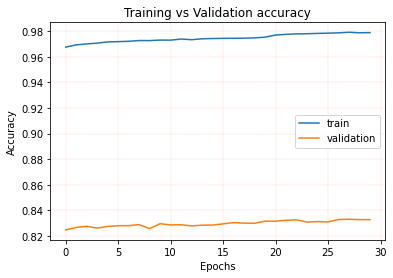

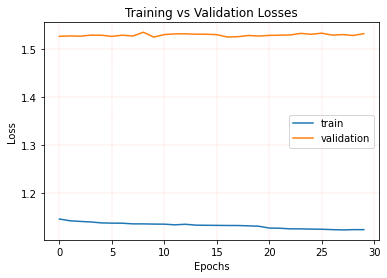

In [31]:
def PlotCurves(model_history):
    plt.plot(model_history.history['accuracy'],label = 'train')
    plt.grid(color = 'r', linestyle = '--', linewidth = .1)    
    #plt.figure()
    plt.plot(model_history.history['val_accuracy'],label = 'validation')
   
    plt.ylabel('Accuracy');
    plt.xlabel('Epochs');
    
    plt.title('Training vs Validation accuracy');
    plt.legend()
    
    plt.figure()
    
    plt.plot(model_history.history['loss'],label = 'train')
    plt.grid(color = 'r', linestyle = '--', linewidth = .1)    
    plt.plot(model_history.history['val_loss'],label = 'validation')
   
    plt.ylabel('Loss');
    plt.xlabel('Epochs');
    
    plt.title('Training vs Validation Losses');
    plt.legend()
    return None

PlotCurves(history)

In [28]:
#Convert labels to categorical orthonormal vectors
y_val_1hot = tf.keras.utils.to_categorical(y_val, config['num_classes'])

time_stamp = datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')
_, accuracy,top3_acc = model.evaluate([x_val2,coords_val], y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top3_acc * 100, 2)}%")
print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")

_,new_col_length,new_row_length = x_train.shape 
model.save(f'..//all_block_data//PulsedTrainTest//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_Top3Acc{top3_acc:.3f}_{new_row_length}x{new_col_length}.h5') # Last percentage is 46.85, New:52.4

6933/6933 [==============================] - 346s 50ms/step - loss: 1.8850 - accuracy: 0.7199 - top-3-accuracy: 0.8746
Test accuracy: 71.99%
Test top 5 accuracy: 87.46%
Test_time: 25_July_22_2204


In [ ]:
# Convert labels to categorical orthonormal vectors
y_test_1hot = tf.keras.utils.to_categorical(y_test, config['num_classes'])

_, accuracy,top3_acc = model.evaluate(x_test2, y_test_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top3_acc * 100, 2)}%")
print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")



In [ ]:
# Train further
train_further = False

if train_further:
    history = model.fit(x_train, y_train_1hot,
          epochs= 200,          
          validation_split= 0.3,
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]

In [35]:
# Check some predictions

import random
check_start = random.randint(0,len(x_val))

print(f'Check start {check_start}')
[(int(y_val[idx]), np.argmax(model.predict([np.expand_dims(x_val2[idx],axis=0),np.expand_dims(coords_val[idx],axis=0)] )) ) for idx in range(check_start,check_start+20) ]



Check start 9778


[(8, 8),
 (15, 16),
 (12, 12),
 (10, 10),
 (13, 13),
 (15, 15),
 (10, 10),
 (16, 16),
 (9, 9),
 (13, 13),
 (10, 11),
 (20, 20),
 (8, 8),
 (15, 15),
 (14, 14),
 (16, 16),
 (14, 14),
 (10, 9),
 (15, 15),
 (11, 11)]

In [ ]:
# Test model manually on all val data

y_pred = [ np.argmax(model.predict([np.expand_dims(x_val2[idx],axis=0),np.expand_dims(coords_val[idx],axis=0)] )) for idx in range(len(x_val)) ]

combined_result = zip(y_val,y_pred)

val_exact_accuracy = 100 * sum([1 if y_pred[idx]==y_val[idx]   else 0 for idx in range(len(y_pred)) ]) / len(y_pred)
val_margin5_accuracy = 100 * sum([1 if abs(y_pred[idx]-y_val[idx]) < 5 else 0 for idx in range(len(y_pred)) ]) / len(y_pred)

print(f' Exact accuracy is {val_exact_accuracy: .5f} %')
print(f' Top 5% accuracy is {val_margin5_accuracy: .5f} %')



In [ ]:
# Confusion Matrix and ROC/AUC

model_predictions = np.asarray(y_pred)
ground_truth = y_val.squeeze()

# Prediction per Ground-truth class
class_predictions = [ model_predictions[ground_truth==idx]  for idx in range(config['num_classes']) ]

# Confusion matrix
confusion_mtx = np.zeros((config['num_classes'],config['num_classes']) )

for pred,actual in zip(y_pred,y_val): # Rows=Prediction, Columns = Actual
    confusion_mtx[pred,actual] +=1

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(7,15),dpi = 100);
shw=ax.imshow(confusion_mtx)
#bar= plt.colorbar(shw)

_=plt.ylabel('Predictions')
_=plt.xlabel('Actual Class')
_=plt.title('Confusion matrix')

# ax.set_xticklabels(list(range(num_classes)))
# ax.set_yticklabels(list(range(num_classes)))

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#bar.set_label('ColorBar')
_ = plt.colorbar(shw, cax=cax)

In [ ]:
# Histogram of each class prediction
for idx,each_class in enumerate(class_predictions):
    _ = plt.figure()
    _ = plt.title('Class %s'%idx)
    labels, counts = np.unique(each_class, return_counts=True)
    _ = plt.bar(labels, counts, align='center')
    _ = plt.gca().set_xticks(labels)
    _ = plt.show()

In [ ]:
from sklearn.metrics import classification_report

print( classification_report( y_val,y_pred, labels=list(range(config['num_classes'])), zero_division=1 ))

In [ ]:
# Check some predictions

import random
check_start = random.randint(0,len(x_val))

print(f'Check start {check_start}')
[(int(y_val[idx]), np.argmax(model.predict(np.expand_dims(x_val[idx],axis=0))) ) for idx in range(check_start,check_start+20) ]



In [36]:
# Check model on unseen data from 20120330_04

test_cnt = [ (orig_all_idx==elem).sum() for elem in test_echo_idx]
test_coords = []
for elem in test_cnt:
    test_coords.append([*range(elem)])
test_coords = np.concatenate(test_coords).ravel()

# Get all idx of echos in train_echo_idx
val_search_idx = np.where(orig_all_idx == test_echo_idx) #np.where( np.in1d(all_idx,train_echo_idx) )
val_search_idx = list(val_search_idx[0])

test_data = orig_all_data[val_search_idx]
test_target = orig_all_target[val_search_idx]
test_idx = orig_all_idx[val_search_idx]

In [37]:
# Reshape and prepare unseen test_data

test_data = np.reshape( test_data, (test_data.shape[0],max_class,-1),order ='F' )
test_data = test_data[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
test_data = np.transpose(test_data,(0,2,1))
test_target[test_target == max_class+1 ] = 0

In [38]:
test_data2 = np.stack((test_data,)*3, axis=-1) 

In [39]:
seq_length = 9

# Create Coords matrix to be used for Positional Embedding
test_coords_mtx = np.zeros( (len(test_coords),seq_length) )

for idx,each_coord in enumerate(test_coords):
    test_coords_mtx[idx] = np.linspace(0, each_coord, num=seq_length)

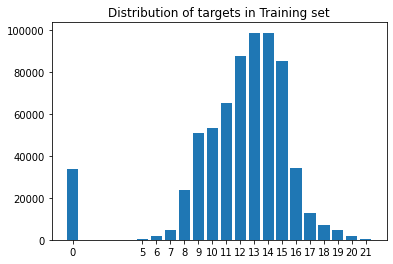

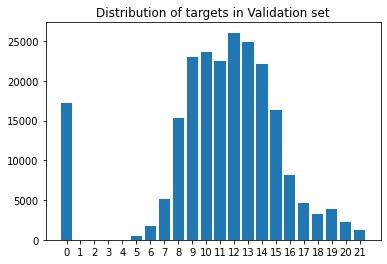

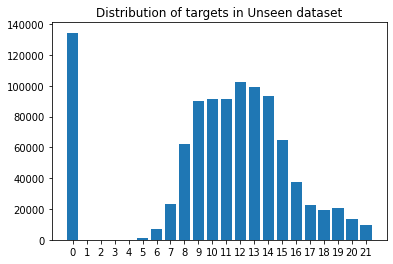

In [40]:
# Show distribution of targets in training and validation set

labels, counts = np.unique(y_train, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Training set')
_ = plt.show()


labels, counts = np.unique(y_val, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Validation set')
_ = plt.show()


labels, counts = np.unique(test_target, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Unseen dataset')
_ = plt.show()

In [41]:
# Convert labels to categorical orthonormal vectors
test_target_1hot = tf.keras.utils.to_categorical(test_target, config['num_classes'])

time_stamp = datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')
_, accuracy,top3_acc = model.evaluate([test_data2,test_coords_mtx], test_target_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top3_acc * 100, 2)}%")
print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")



30788/30788 [==============================] - 1511s 49ms/step - loss: 2.7034 - accuracy: 0.4489 - top-3-accuracy: 0.7518
Test accuracy: 44.89%
Test top 5 accuracy: 75.18%
Test_time: 25_July_22_2240


In [42]:
# Test model manually on all val data

y_pred = [ np.argmax(model.predict([np.expand_dims(test_data[idx],axis=0),np.expand_dims(test_coords_mtx[idx],axis=0)] )) for idx in range(len(test_target)) ]

val_exact_accuracy = 100 * sum([1 if y_pred[idx]==test_target[idx]   else 0 for idx in range(len(y_pred)) ]) / len(y_pred)
val_margin5_accuracy = 100 * sum([1 if abs(y_pred[idx]-test_target[idx]) < 3 else 0 for idx in range(len(y_pred)) ]) / len(y_pred)

print(f' Exact accuracy is {val_exact_accuracy: .5f} %')
print(f' Top 3% accuracy is {val_margin5_accuracy: .5f} %')



 Exact accuracy is  9.53547 %
 Top 3% accuracy is  20.93480 %


In [43]:
# Confusion Matrix and ROC/AUC

model_predictions2 = np.asarray(y_pred)
ground_truth2 = test_target.squeeze()

# Prediction per Ground-truth class
class_predictions2 = [ model_predictions2[ground_truth2==idx]  for idx in range(config['num_classes']) ]

# Confusion matrix
confusion_mtx2 = np.zeros((config['num_classes'],config['num_classes']) )

for pred,actual in zip(y_pred,test_target): # Rows=Prediction, Columns = Actual
    confusion_mtx2[pred,actual] +=1

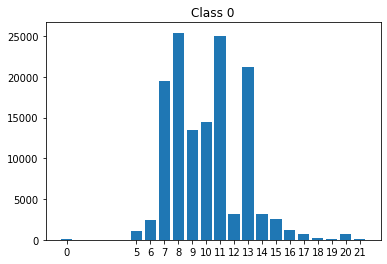

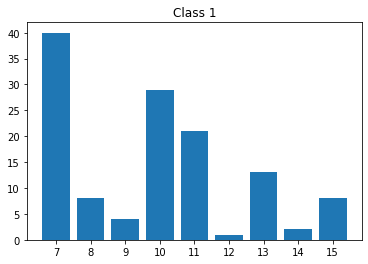

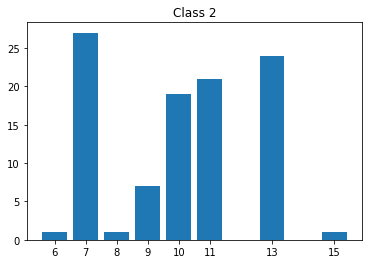

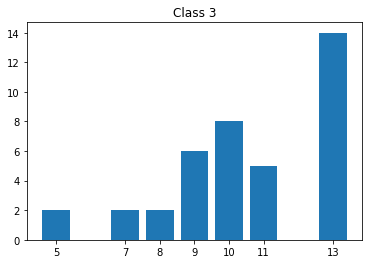

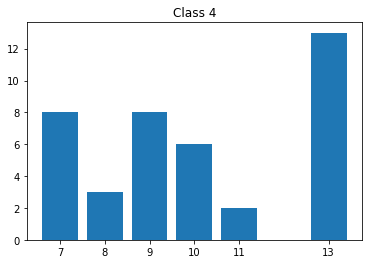

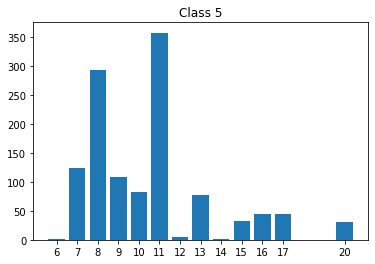

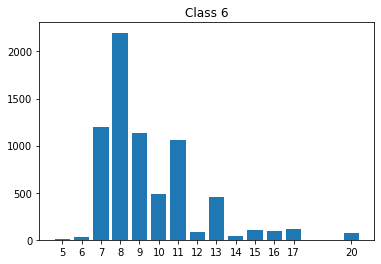

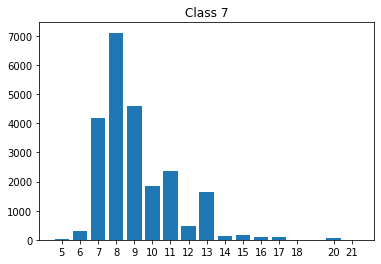

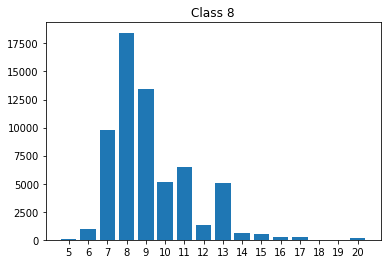

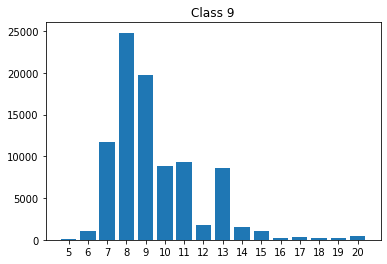

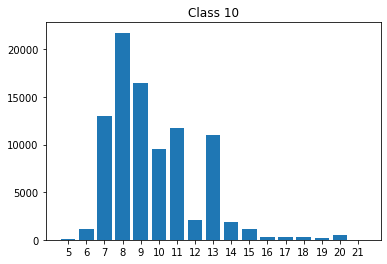

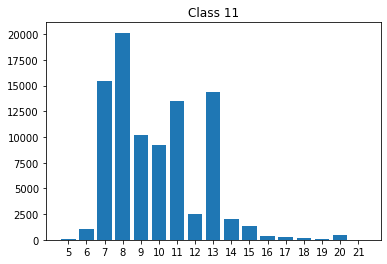

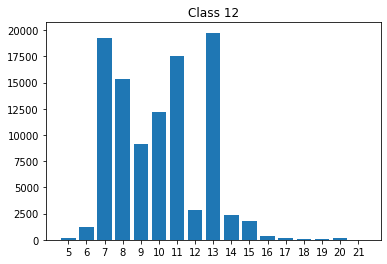

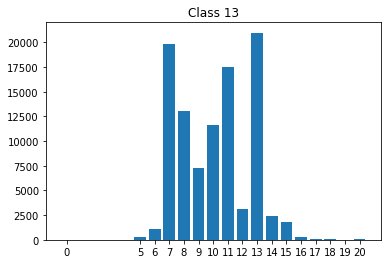

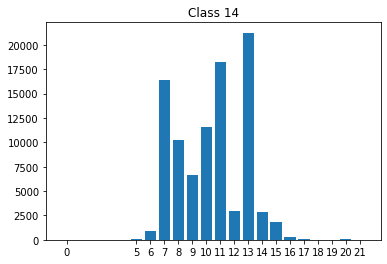

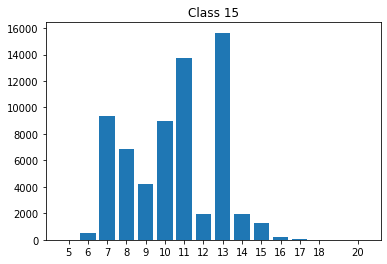

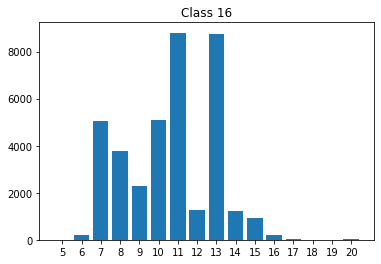

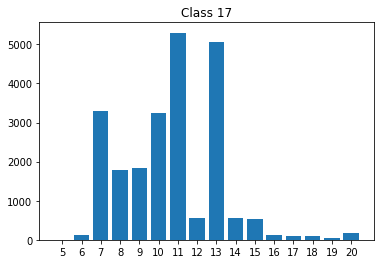

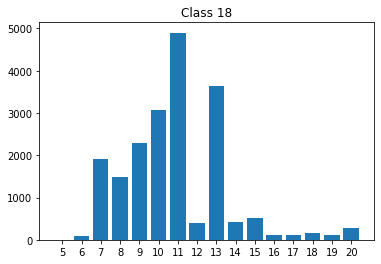

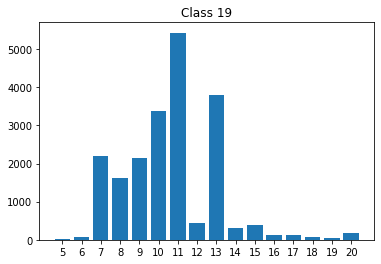

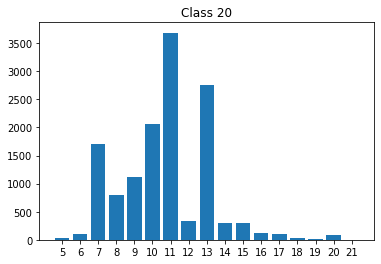

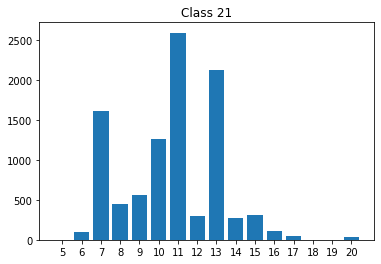

In [44]:
# Histogram of each class prediction
for idx,each_class in enumerate(class_predictions2):
    _ = plt.figure()
    _ = plt.title('Class %s'%idx)
    labels, counts = np.unique(each_class, return_counts=True)
    _ = plt.bar(labels, counts, align='center')
    _ = plt.gca().set_xticks(labels)
    _ = plt.show()

In [ ]:
from sklearn.metrics import classification_report

print( classification_report( test_target,y_pred, labels=list(range(config['num_classes'])), zero_division=1 ))

In [ ]:
# Try prediction on difficult data

x_difficult = raw_data1['echo_cnn_input'][stop_idx+1:]
y_difficult = raw_data1['echo_cnn_target'][stop_idx+1:]

x_difficult = np.reshape( x_difficult, (x_difficult.shape[0],max_class,-1) )
x_difficult = x_difficult[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
x_difficult = np.transpose(x_difficult,(0,2,1))

# y_difficult[y_difficult == num_classes] = 0
# y_difficult = tf.keras.utils.to_categorical(y_difficult, num_classes)


In [ ]:
(x_difficult.shape,y_difficult.shape)

In [ ]:
# Check some predictions

difficult_start = random.randint(0,len(x_val)) #3500 #

print(f'Check start {difficult_start}')
[(int(y_difficult[idx]), np.argmax(model.predict(np.expand_dims(x_difficult[idx],axis=0))) ) for idx in range(difficult_start,difficult_start+50) ]



In [ ]:
# Attempt loading past model (after crash) and start training again
load_model = 0
if load_model:
    model2 = tf.keras.models.load_model(r'Y:\ibikunle\Python_Project\Fall_2021\all_block_data\Old_data\Dec_Train_block_len_21_131121_2213\NewAttention_RowBlockLSTM1\22_November_21_0929_Acc_0.669_Top3Acc0.8506_21x9.h5'
                                    ,)

In [ ]:
# Train further
batch_size = 64
history2 = model.fit(x_train, y_train_1hot,
          epochs= 30, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test_1hot),callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]callbacks=callbacks

In [ ]:
# Train further still( 30th Nov.,2021 X_train is returned back to default [i.e No shuffle] )
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
batch_size = 64
history2 = model.fit(x_train, y_train_1hot,
          epochs= 2, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test_1hot),callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]callbacks=callbacks

In [ ]:
# Convert labels to categorical orthonormal vectors
y_val_1hot = tf.keras.utils.to_categorical(y_val, num_classes)

_, accuracy,top3_acc = model.evaluate(x_val, y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

_,new_col_length,new_row_length = x_train.shape 
model.save(f'{base_path}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_Top3Acc{top3_acc:.3f}_{new_row_length}x{new_col_length}.h5')

In [ ]:
# Test model on val data

y_diff_pred = [ np.argmax(model.predict(np.expand_dims(x_difficult[idx],axis=0))) for idx in range(3000,3050) ] #len(x_difficult)

difficult_exact_accuracy = 100 * sum([1 if y_diff_pred[idx]==y_difficult[idx]   else 0 for idx in range(len(y_diff_pred)) ]) / len(y_diff_pred)
difficult_margin5_accuracy = 100 * sum([1 if abs(y_diff_pred[idx]-y_difficult[idx]) < 3 else 0 for idx in range(len(y_diff_pred)) ]) / len(y_diff_pred)

print(f' Exact accuracy is {difficult_exact_accuracy: .5f} %')
print(f' Top 5% accuracy is {difficult_margin5_accuracy: .5f} %')



In [ ]:
len(y_diff_pred)